# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotion import * 
from MCSAmericanOptionPricing import *
import math

seed = 1 #time.time()
random.seed(seed)
print('Seed is:' + str(seed))

Seed is:1


### Variable settings

In [2]:
risk_free_rate = 5/100

In [3]:
save_model_freq = 10000 #5000
Normalization = False
Window_Normalization = False
test_data_ratio = 0.6

architecture = 0
nbFilters = 32
paddingType = 'same'
huber_loss = True
dueling_type = 'max'
mask_type = 'default'
apply_dropout = True
batch_size = 64 #How many experience traces to use for each training step.
memory_capacity = 10000
learning_rate = 0.005
apply_grad_clipping = True
grad_clipping = 5
optimizer_type = 'Adam'

Colab = False
scriptDirectory = os.getcwd()

history_t = 15
option_T = 50
input_size = history_t + 2
is_training = True

##hpq.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 8.53125, max value of data: 22.20295
train_size: 367
test_size: 549
##aapl.us.txtmin date: 1984-09-07max date: 2017-11-10
min value of data: 68.814, max value of data: 174.825
train_size: 367
test_size: 549
##goog.us.txtmin date: 2014-03-27max date: 2017-11-10
min value of data: 491.77, max value of data: 1035.9850000000001
train_size: 367
test_size: 549
##ibm.us.txtmin date: 1962-01-02max date: 2017-11-10
min value of data: 110.81, max value of data: 176.43
train_size: 367
test_size: 549
##ups.us.txtmin date: 1999-11-10max date: 2017-11-10
min value of data: 83.2025, max value of data: 119.64
train_size: 367
test_size: 549
##jnj.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 83.78399999999999, max value of data: 143.231
train_size: 367
test_size: 549
##msft.us.txtmin date: 1986-03-13max date: 2017-11-10
min value of data: 35.632999999999996, max value of data: 84.905
train_size: 367
test_size: 5

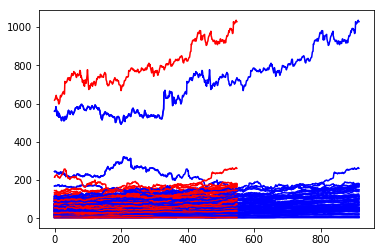

In [4]:
stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(test_data)), test_data, color='r')    

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 283
num_episodes_per_epoch: 18120
min value of stock: 79.153, max value of stock: 101.875


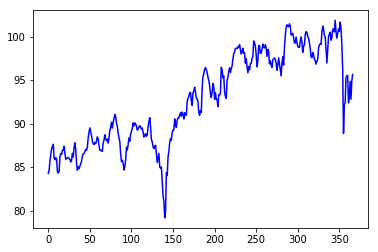

In [5]:
############################################################################
#env = StockEnv(train_data, risk_free_rate, history_t=history_t, option_T=option_T)
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

### Implementing the network itself

In [6]:
class Qnetwork():
    def __init__(self,myScope):
        
        self.scalarInput = tf.placeholder(shape=[None,input_size],dtype=tf.float32)
        
        # depending on the chosen architecture, data is processed through differents layers
        
        # convolutions are used in all type, except architecture 0 which only uses LSTM
        if architecture != 0:
          self.InputConvIn = tf.reshape(self.scalarInput,shape=[-1,input_size,1], name='InputConvIn')
          self.conv1 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.InputConvIn)
        
        if architecture == 0: # LSTM only
          self.scalarInputFlattened = tf.keras.layers.Flatten()(self.scalarInput)
        elif architecture == 1: # only one convolution
          self.conv1flattened = tf.reshape(self.conv1,shape=[-1,self.conv1.shape[1]*self.conv1.shape[2]], name='conv1flattened')
        elif architecture == 2: # only one convolution followed by max pooling
          self.maxPooling1D = tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.maxPooling1Dflattened = tf.reshape(self.maxPooling1D,shape=[-1,self.maxPooling1D.shape[1]*self.maxPooling1D.shape[2]], name='maxPooling1Dflattened')
        elif architecture == 3: # only one convolution followed by average pooling
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.AveragePooling1Dflattened = tf.reshape(self.AveragePooling1D,shape=[-1,self.AveragePooling1D.shape[1]*self.AveragePooling1D.shape[2]], name='AveragePooling1Dflattened')  
        elif architecture == 4: #VGG (one block of 2 convolutions followed by avg pooling)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.conv1)
          self.AveragePooling1D4 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened4 = tf.reshape(self.AveragePooling1D4,shape=[-1,self.AveragePooling1D4.shape[1]*self.AveragePooling1D4.shape[2]], name='AveragePooling1Dflattened4')
        elif architecture == 5: #Lenet (conv, avg pooling, conv, avg pooling)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,#5, #3, #maybe unstable calculations because of 5 instead of 3
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.AveragePooling1D5 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened5 = tf.reshape(self.AveragePooling1D5,shape=[-1,self.AveragePooling1D5.shape[1]*self.AveragePooling1D5.shape[2]], name='AveragePooling1Dflattened5')
        elif architecture == 6: #Googlenet (Inception net: combine (conv&avgPooling) + conv1 + conv3 + conv5)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv11 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=1,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv3 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=3,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv5 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=5,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.filterconcatenation = tf.concat([self.conv11, self.conv3, self.conv5, self.AveragePooling1D], 2, name = 'filterconcatenation')
          self.filterconcatenationflattened = tf.reshape(self.filterconcatenation,shape=[-1,self.filterconcatenation.shape[1]*self.filterconcatenation.shape[2]], name='filterconcatenationflattened')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
 
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        if architecture == 0:
          self.convFlat = tf.reshape(self.scalarInputFlattened,[self.batch_size,self.trainLength,input_size])
        elif architecture == 1:
          self.convFlat = tf.reshape(self.conv1flattened,[self.batch_size,self.trainLength,self.conv1flattened.shape[1]])
        elif architecture == 2:
          self.convFlat = tf.reshape(self.maxPooling1Dflattened,[self.batch_size,self.trainLength,self.maxPooling1Dflattened.shape[1]])
        elif architecture == 3:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened.shape[1]])
        elif architecture == 4:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened4,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened4.shape[1]])
        elif architecture == 5:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened5,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened5.shape[1]])
        elif architecture == 6:
          self.convFlat = tf.reshape(self.filterconcatenationflattened,[self.batch_size,self.trainLength,self.filterconcatenationflattened.shape[1]])
        
        # use cudnn-based cells to leverage Nvidia GPUs
        single_cell = lambda: tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(h_size)
    
        # NOTE: Even if there's only one layer, the cell needs to be wrapped in MultiRNNCell.
        lstm_cells = [single_cell() for _ in range(num_layers)]
        if is_training and apply_dropout and dropout < 1:
            lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout
            ) for lstm in lstm_cells]
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

        self.state_in = tf.placeholder(tf.float32, [num_layers, 2, None, h_size])
        state_per_layer_list = tf.unstack(self.state_in, axis=0)
        rnn_tuple_state = tuple(
            [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )
        
        # calculate the real length of each episode (since remaining states are filled with 0s after selling)
        # This is required by RNN 
        self.seq_len = length(self.convFlat)
        
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                cell=multi_cell,
                inputs=self.convFlat,                                    
                dtype=tf.float32,
                initial_state=rnn_tuple_state, 
                sequence_length=self.seq_len,
                scope=myScope+'_lstm')
        

        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        #The output from the LSTM is then split into separate Value and Advantage streams
        self.streamA,self.streamV = tf.split(self.rnn,2,1)
        initializer = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(initializer([h_size//2,2]))
        self.VW = tf.Variable(initializer([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        if dueling_type == 'avg':
            self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        elif dueling_type == 'max':
            self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_max(self.Advantage,axis=1,keep_dims=True))
        elif dueling_type == 'naive':
            self.Qout = self.Value + self.Advantage
        
        self.predict = tf.argmax(self.Qout,1)
        
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        # calculate the temporal difference error.
        if huber_loss == True:
            self.td_error = tf.losses.huber_loss(self.targetQ, self.Q, reduction=tf.losses.Reduction.NONE)
        else:
            self.td_error = tf.square(self.targetQ - self.Q)
            
        #For test purpose
        self.Q_sell_error = tf.square(self.Qout[:,1] - self.scalarInput[:,0])
        self.Q_sell_loss = tf.cast(tf.reduce_sum(self.Q_sell_error), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)

        # In order to only propogate accurate gradients through the network, we can mask the first
        # half of the losses for each trace as per Lample & Chaplot 2016
        # We can also use gradual weights to avoid neglecting short episodes at the beginning
        # maybe seq_len used in averaging should also change subsequently !
        if mask_type == 'maskFirstHalf':
            self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
            self.maskB = tf.ones([self.batch_size,self.trainLength//2])
            self.mask = tf.concat([self.maskA,self.maskB],1)
            self.mask = tf.reshape(self.mask,[-1])
            self.td_error = self.td_error * self.mask
        elif mask_type == 'maskByWeights': 
            #self.mask_weights = tf.range(start=0, limit=1, delta=1/self.trainLength)
            self.mask_weights = tf.range(start=0.1, limit=1, delta=0.9/tf.cast(self.trainLength, tf.float32))
            self.mask = tf.tile(self.mask_weights, [self.batch_size])
            self.td_error = tf.multiply(self.td_error, tf.cast(self.mask, tf.float32))
        elif mask_type == 'default':
            self.td_error = self.td_error
        
        # divide by the real length of episodes instead of averaging which is incorrect
        self.loss = tf.cast(tf.reduce_sum(self.td_error), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)
        self.check_ops = tf.debugging.check_numerics( self.loss, "self.loss contain Nan or Inf", name="self.check_ops")
        
        if optimizer_type == 'Adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        elif optimizer_type == 'GradientDescent':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        elif optimizer_type == 'RMSProp':
            optimizer = tf.train.RMSPropOptimizer(learning_rate)
        
        if apply_grad_clipping:
            # calculate gradients and clip them to handle outliers
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), grad_clipping)
            self.updateModel = optimizer.apply_gradients(
                    zip(grads, tvars),
                    # global_step=tf.contrib.framework.get_or_create_global_step(),
                    name="updateModel")
        else:
            self.updateModel = optimizer.minimize(self.loss, name="updateModel")

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [7]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [8]:
#Setting the training parameters
num_layers = 3 # Number of layer of LSTM
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #30 #10 #5 #How often to perform a training step.
update_online_freq = 5
update_target_freq = 300
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
num_epochs = 5
num_episodes = env.get_total_num_episodes_per_epoch()*num_epochs
pre_train_episodes = int(memory_capacity * 0.1)
annealing_episodes = int(num_episodes * 0.3)
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
summaryEpoch = env.get_total_num_episodes_per_epoch()
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = False # use soft or hard updates
trained_model_name = os.path.join(path, 'RL_' + str(architecture)\
                    + '-option_T' + str(option_T) + '-history_t' + str(history_t)\
                    + '-dueling_type' + str(dueling_type)\
                    + '-freq' + str(update_target_freq) + '-batch' + str(batch_size)\
                    + '-capacity' + str(memory_capacity) + '-lambda' + str(learning_rate))

final_trained_model_name = trained_model_name + '-final'
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
print('#gamma: ' + str(gamma))

#num_episodes: 90600
#trace_length: 38
#gamma: 0.9998016069840849


In [ ]:
begin_time = time.time()
tf.reset_default_graph()
#We define the primary and target q-networks
mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau,softUpdate)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
# amounts by which to anneal
episodeDrop = (startE - endE)/annealing_episodes

episodeDrop2 = (endE - exploitationE)/annealing_exploitation_episodes

#create lists to contain total rewards, steps per episode, sell time and epsilon
jList = []
rList = []
sTimeList = [] # sell time list
eList = []

percentage_rList = []
real_percentage_rList = []

NonRandom_percentage_rList = []
NonRandom_real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

NonRandom_option_percentage_rList = []
NonRandom_option_real_percentage_rList = []

#Non random day Lists
NonRandomrList = []
NonRandomsTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
AvgEpisodeListEpoch = []
AvgrListEpoch = []
AvgsTimeListEpoch = []

AvgLossList = []
AvgQSellLossList = []
AvgMainQList = []
AvgTargetQList = []
AvgMainMaxQList = []
AvgMainHoldQList = []
AvgMainSellQList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

##### Temp
AvgLossListEpochTemp = []
AvgQSellLossListEpochTemp = []
AvgMainQListEpochTemp = []
AvgTargetQListEpochTemp = []
AvgMainMaxQListEpochTemp = []
AvgMainHoldQListEpochTemp = []
AvgMainSellQListEpochTemp = []
# permanent
AvgLossListEpoch = []
AvgQSellLossListEpoch = []
AvgMainQListEpoch = []
AvgTargetQListEpoch = []
AvgMainMaxQListEpoch = []
AvgMainHoldQListEpoch = []
AvgMainSellQListEpoch = []
#####

# Non random days
AvgNonRandomrList = []
AvgNonRandomsTimeList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)  

#Some config to parralelize and leverage the GPU capabilities.
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 0 #16 #44
config.inter_op_parallelism_threads = 0 #16 #44
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
#config.device_count = {"CPU": 4}, # limit to num_cpu_core CPU usage 
#config.log_device_placement = True
#tf.Session(config=config)

with tf.Session(config=config) as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
   
    updateTarget(targetOps,sess) #Update the target network.
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        #print('sP: ' + str(sP))
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the lstm's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        
        if exploration_type == 'Random' and np.random.rand(1) < e:
            sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        else:
            sell_time = -1
            
        while j < max_epLength: 
            #Choose an action greedily (with e chance of random action) from the Q-network
            if env.is_episode_finished(): # fill with empty state till the end to have episodes of equal length to train
                a = 0 # arbitrary
                s1P,r,d = env.empty_step()
            else:
                if i < pre_train_episodes or env.get_time() < build_warm_up_state_t or sell_time != -1:    
                    #construct the state for following steps of same episode
                    if sell_time != -1:
                        state1 = np.zeros((num_layers, 2, 1, h_size))
                    else:
                        state1 = sess.run(mainQN.rnn_state,\
                            feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                    
                    if env.get_time() < build_warm_up_state_t or env.get_payoff() <= 0:
                        a = 0 #hold
                    elif sell_time != -1:
                        if j == sell_time and d == False:
                            a = 1
                        else:
                            a = 0
                    elif j == max_epLength - 1 and d == False:
                        a = 1
                    else:
                        a = np.random.randint(0,2)

                else:
                    a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                    a = a[0]
            
                s1P,r,d = env.step(a)
                #print('s1P: ' + str(s1P))
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        eList.append(e)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        if sell_time == -1:
            NonRandomrList.append(rAll)
            NonRandomsTimeList.append(env.get_sell_time() + 1)
            #NonRandom_percentage_rList.append(env.get_percentage_return())
            #NonRandom_real_percentage_rList.append(env.get_real_percentage_return())
            
            stock_percentage_return, option_percentage_return = env.get_percentage_return()
            NonRandom_percentage_rList.append(stock_percentage_return)
            NonRandom_option_percentage_rList.append(option_percentage_return)
            stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
            NonRandom_real_percentage_rList.append(stock_percentage_return)
            NonRandom_option_real_percentage_rList.append(option_percentage_return)
            

        if i >= pre_train_episodes:
            #Reset the lstm's hidden state
            state_train = np.zeros((num_layers, 2, batch_size, h_size))
            #Get a random batch of experiences.
            trainBatch = myBuffer.sample(batch_size)
            #Below we perform the Double-DQN update to the target Q-values
            Q1, main_Q = sess.run([mainQN.predict, mainQN.Qout], feed_dict={\
                                mainQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            Q2 = sess.run(targetQN.Qout, feed_dict={\
                                targetQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
            terminal = -(trainBatch[:,4] - 1) # done or not to add the future reward or not
            doubleQ = Q2[range(batch_size*trace_length),Q1]
            targetQ = trainBatch[:,2] + (gamma*doubleQ * terminal)
            #Update the network with our target values.
            loss,Q_sell_loss, _, _ = sess.run([mainQN.loss, mainQN.Q_sell_loss, mainQN.check_ops, mainQN.updateModel], \
                                feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ,\
                                mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                                mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            # perform soft/hard update frequently
            if i % update_target_freq == 0 or update_target_freq == 1 or softUpdate == True:
                updateTarget(targetOps,sess)
                

        #Periodically save the model and print metrics. 
        if i % save_model_freq == 0 and i != 0:
            #saver.save(sess,path+'/model-'+str(i)+'.cptk')
            saver.save(sess,trained_model_name, global_step=i)
            print ("Saved Model")
            inter_time = time.time()
            print('#Intermediate time to execute: '+ str((inter_time - begin_time)/60) + 'min')
        
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            
            if i >= pre_train_episodes:
                AvgLossList.append(loss)
                AvgQSellLossList.append(Q_sell_loss)
                AvgMainQList.append(np.mean(main_Q))
                AvgTargetQList.append(np.mean(Q2))
                #print(main_Q)
                #print(tf.reduce_max(main_Q,1))
                AvgMainMaxQList.append(np.mean(np.amax(main_Q, axis=1)))
                AvgMainHoldQList.append(np.mean(np.array(main_Q)[:,0]))
                AvgMainSellQList.append(np.mean(np.array(main_Q)[:,1]))
                
                #per epoch temporary array to store values per epoch then erase for new epochs
                AvgLossListEpochTemp.append(loss)
                AvgQSellLossListEpochTemp.append(Q_sell_loss)
                AvgMainQListEpochTemp.append(np.mean(main_Q))
                AvgTargetQListEpochTemp.append(np.mean(Q2))
                #print(main_Q)
                #print(tf.reduce_max(main_Q,1))
                AvgMainMaxQListEpochTemp.append(np.mean(np.amax(main_Q, axis=1)))
                AvgMainHoldQListEpochTemp.append(np.mean(np.array(main_Q)[:,0]))
                AvgMainSellQListEpochTemp.append(np.mean(np.array(main_Q)[:,1]))
                
                
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        
        if len(NonRandomrList) % summaryLength == 0 and len(NonRandomrList) != 0:
            AvgNonRandomR = np.mean(NonRandomrList[-summaryLength:])
            AvgNonRandomsT = np.mean(NonRandomsTimeList[-summaryLength:])
            AvgNonRandomrList.append(AvgNonRandomR)
            AvgNonRandomsTimeList.append(AvgNonRandomsT)
                

        if i > pre_train_episodes:
            if e > endE:
                e -= episodeDrop
            if i >= pre_exploitation_episodes:
                if e > exploitationE:
                    e -= episodeDrop2
                
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
        
        if len(rList) % summaryEpoch == 0 and len(rList) != 0:
            AvgREpoch = np.mean(rList[-summaryEpoch:])
            AvgsTEpoch = np.mean(sTimeList[-summaryEpoch:])
            AvgEpisodeListEpoch.append(i+1)
            AvgrListEpoch.append(AvgREpoch)
            AvgsTimeListEpoch.append(AvgsTEpoch)
            
            #loss
            Avgloss = np.mean(AvgLossListEpochTemp)
            AvgQ_sell_loss = np.mean(AvgQSellLossListEpochTemp)
            Avgmain_Q = np.mean(AvgMainQListEpochTemp)
            AvgTargetQ = np.mean(AvgTargetQListEpochTemp)
            AvgMainMaxQ = np.mean(AvgMainMaxQListEpochTemp)
            AvgMainHoldQ = np.mean(AvgMainHoldQListEpochTemp)
            AvgMainSellQ = np.mean(AvgMainSellQListEpochTemp)
            
            AvgLossListEpoch.append(Avgloss)
            AvgQSellLossListEpoch.append(AvgQ_sell_loss)
            AvgMainQListEpoch.append(np.mean(Avgmain_Q))
            AvgTargetQListEpoch.append(AvgTargetQ)
            AvgMainMaxQListEpoch.append(AvgMainMaxQ)
            AvgMainHoldQListEpoch.append(AvgMainHoldQ)
            AvgMainSellQListEpoch.append(AvgMainSellQ)
            # empty arrays
            AvgLossListEpochTemp = []
            AvgQSellLossListEpochTemp = []
            AvgMainQListEpochTemp = []
            AvgTargetQListEpochTemp = []
            AvgMainMaxQListEpochTemp = []
            AvgMainHoldQListEpochTemp = []
            AvgMainSellQListEpochTemp = []
            
            
    # Do a final save        
    #saver.save(sess,path+'/model-'+str(i)+'.cptk')  
    saver.save(sess,final_trained_model_name)  
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Total average reward per non-random episode: " + str(np.mean(AvgNonRandomrList)))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Percentage of Non Random stock returns (Normalized): " + str(np.mean(NonRandom_percentage_rList)))

print ("#Percentage of Non Random stock returns (Real values): " + str(np.mean(NonRandom_real_percentage_rList)))

print ("#Percentage of Non Random option returns (Normalized): " + str(np.mean(NonRandom_option_percentage_rList)))

print ("#Percentage of Non Random option returns (Real values): " + str(np.mean(NonRandom_option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))
    
end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

In [ ]:
def movingaverage (values):
    cum_sum = np.cumsum(values) 
    div = np.arange(1,len(values) + 1)
    sma = np.divide(cum_sum, div)
    return sma

AvgNonRandomrListMA = movingaverage(AvgNonRandomrList)

AvgNonRandomsTimeListMA = movingaverage(AvgNonRandomsTimeList)


In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), AvgNonRandomrList, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), AvgNonRandomrListMA, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

# per epoch

In [ ]:
AvgrListMAEpoch = movingaverage(AvgrListEpoch)

AvgsTimeListMAEpoch = movingaverage(AvgsTimeListEpoch)

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), AvgrListEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), AvgrListMAEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossListEpoch)), AvgLossListEpoch, color='blue', label='Average batch loss')
plt.plot(range(len(AvgQSellLossListEpoch)), AvgQSellLossListEpoch, color='red', label='Average batch loss for sell')
plt.title('Batch loss per Epoch')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgMainQListEpoch)), AvgMainQListEpoch, color='blue', label='Average batch Main Q')
plt.plot(range(len(AvgTargetQListEpoch)), AvgTargetQListEpoch, color='red', label='Average batch Target Q')
plt.plot(range(len(AvgMainMaxQListEpoch)), AvgMainMaxQListEpoch, color='green', label='Average batch Main max Q')
plt.plot(range(len(AvgMainHoldQListEpoch)), AvgMainHoldQListEpoch, color='black', label='Average batch Main hold Q')
plt.plot(range(len(AvgMainSellQListEpoch)), AvgMainSellQListEpoch, color='orange', label='Average batch Main sell Q')
plt.title('Batch Q per Epoch')
plt.xlabel('episodes')
plt.ylabel('Average batch Q')
plt.legend(loc='best');

In [ ]:
AvgrListMA = movingaverage(AvgrList)

AvgsTimeListMA = movingaverage(AvgsTimeList)

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrListMA, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossList)), AvgLossList, color='blue', label='Average batch loss')
plt.plot(range(len(AvgQSellLossList)), AvgQSellLossList, color='red', label='Average batch loss for sell')
plt.title('Batch loss over time')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgMainQList)), AvgMainQList, color='blue', label='Average batch Main Q')
plt.plot(range(len(AvgTargetQList)), AvgTargetQList, color='red', label='Average batch Target Q')
plt.plot(range(len(AvgMainMaxQList)), AvgMainMaxQList, color='green', label='Average batch Main max Q')
plt.plot(range(len(AvgMainHoldQList)), AvgMainHoldQList, color='black', label='Average batch Main hold Q')
plt.plot(range(len(AvgMainSellQList)), AvgMainSellQList, color='orange', label='Average batch Main sell Q')
plt.title('Batch Q over time')
plt.xlabel('episodes')
plt.ylabel('Average batch Q')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

In [ ]:
sTimeListMA = movingaverage(sTimeList)

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeListMA)), sTimeListMA, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(num_episodes), eList, color='blue', label='Probability of random action')
plt.title('Probability of random action over time')
plt.xlabel('episodes')
plt.ylabel('Probability of random action')
plt.legend(loc='best');

### Testing the network

In [9]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

In [ ]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [ ]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

totalAveragerewardPerEpisode = np.mean(rList)
maxPossibleAveragerewardPerEpisode = np.mean(maxPossiblerList)
CI90 = env.getConfidenceInterval(rList)
CI95 = env.getConfidenceInterval95(rList)
sEntropy = env.getEntropy(sTimeList)
percentageStockReturnNormalized = np.mean(percentage_rList)
percentageStockReturnReal = np.mean(real_percentage_rList)
percentageOptionReturnNormalized = np.mean(option_percentage_rList)
percentageOptionReturnReal = np.mean(option_real_percentage_rList)
maxPossibleAverageStockPercentageReturnPerEpisode = np.mean(maxPossibleP_returnList)
maxPossibleAverageRealStockPercentageReturnPerEpisode = np.mean(maxPossibleR_P_returnList)
maxPossibleAverageOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionP_returnList)
maxPossibleAverageRealOptionPercentageReturnPerEpisode = np.mean(maxPossibleOptionR_P_returnList)
CIPercentageReturnNormalized90 = env.getConfidenceInterval(percentage_rList)
CIPercentageReturnNormalized95 = env.getConfidenceInterval95(percentage_rList)
CIPercentageReturnReal90 = env.getConfidenceInterval(real_percentage_rList)
CIPercentageReturnReal95 = env.getConfidenceInterval95(real_percentage_rList)
CIPercentageOptionReturnNormalized90 = env.getConfidenceInterval(option_percentage_rList)
CIPercentageOptionReturnNormalized95 = env.getConfidenceInterval95(option_percentage_rList)
CIPercentageOptionReturnReal90 = env.getConfidenceInterval(option_real_percentage_rList)
CIPercentageOptionReturnReal95 = env.getConfidenceInterval95(option_real_percentage_rList)
print ("#Total average reward per episode: " + str(totalAveragerewardPerEpisode))

print ("#Max possible average reward per episode: " + str(maxPossibleAveragerewardPerEpisode))

print ("#Confidence Interval with prob of 90%: " + str(CI90))

print ("#Confidence Interval with prob of 95%: " + str(CI95))

print ("#Sell time entropy: " + str(sEntropy))

print ("#Percentage of stock returns (Normalized): " + str(percentageStockReturnNormalized))

print ("#Percentage of stock returns (Real values): " + str(percentageStockReturnReal))

print ("#Percentage of option returns (Normalized): " + str(percentageOptionReturnNormalized))

print ("#Percentage of option returns (Real values): " + str(percentageOptionReturnReal))

print ("#Max possible average stock percentage return per episode: " + str(maxPossibleAverageStockPercentageReturnPerEpisode))

print ("#Max possible average real stock percentage return per episode: " + str(maxPossibleAverageRealStockPercentageReturnPerEpisode))

print ("#Max possible average option percentage return per episode: " + str(maxPossibleAverageOptionPercentageReturnPerEpisode))

print ("#Max possible average real option percentage return per episode: " + str(maxPossibleAverageRealOptionPercentageReturnPerEpisode))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(CIPercentageReturnNormalized90))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(CIPercentageReturnNormalized95))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(CIPercentageReturnReal90))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(CIPercentageReturnReal95))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(CIPercentageOptionReturnNormalized90))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(CIPercentageOptionReturnNormalized95))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(CIPercentageOptionReturnReal90))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(CIPercentageOptionReturnReal95))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Min price over history [Benchmark]

In [ ]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'MinValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Max price over history [Benchmark]

In [ ]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'MaxValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [ ]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [ ]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select first day over history to sell [Benchmark]

In [ ]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'FirstDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = [] 

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'FirstDay':
          sell_time = build_warm_up_state_t 
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'FirstDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Validation part

['HPQ', 'AAPL', 'GOOG', 'UPS', 'JNJ', 'MSFT', 'PG', 'TSN', 'USA', 'TEX', 'SAM', 'SALT', 'TLYS', 'TRQ', 'TRNO', 'TNP', 'TJX', 'TPX', 'FB', 'JPM', 'V', 'BAC', 'MA', 'HD', 'TSM', 'DIS', 'INTC', 'VZ', 'RDS-B', 'TM', 'CVX', 'WFC', 'NVS', 'KO', 'MRK', 'CMCSA', 'SAP', 'CHL', 'UL', 'BUD', 'UN', 'WFC', 'MDT', 'HSBC', 'MCD', 'NKE', 'ADBE', 'CRM', 'TOT', 'PTR', 'COST', 'PM', 'AMGN', 'ABBV', 'HON', 'T', 'GM', 'CVS', 'UNH', 'XOM', 'BRK-A', 'WMT', 'MCK', 'AAT', 'ABC', 'ACRE', 'FN', 'FNB', 'FORD', 'KRG', 'PEG', 'TG', 'NFLX', 'ACN', 'UTX', 'LMT', 'NVDA', 'AVGO', 'AZN', 'TMO', 'UNP', 'LFC', 'BHP', 'SNY', 'BBL', 'NEE', 'TXN', 'LLY', 'QCOM', 'DHR', 'CHTR', 'SBUX', 'MMM', 'AXP', 'HDB', 'TD', 'NVO', 'ASML', 'RY', 'CSCO', 'ORCL', 'C']
[*********************100%***********************]  1 of 1 completed
##HPQmin date: 2017-11-10 00:00:00max date: 2019-12-10 00:00:00
min value of data: 16.05500030517578, max value of data: 26.649999618530273
train_size: 210
test_size: 313
[*********************100%***********

[*********************100%***********************]  1 of 1 completed
##FNmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 24.55500030517578, max value of data: 61.55500030517578
train_size: 209
test_size: 313
[*********************100%***********************]  1 of 1 completed
##FNBmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 9.524999618530273, max value of data: 14.789999961853027
train_size: 209
test_size: 313
[*********************100%***********************]  1 of 1 completed
##FORDmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 0.949999988079071, max value of data: 3.3899998664855957
train_size: 209
test_size: 313
[*********************100%***********************]  1 of 1 completed
##KRGmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 13.90999984741211, max value of data: 20.09000015258789
train_size: 209
test_size: 313
[*********************100%****************

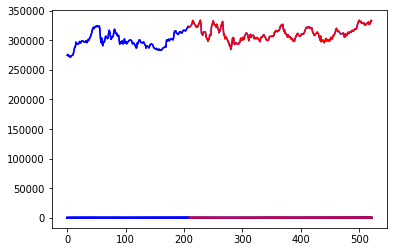

In [10]:
stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ups.us.txt', #'ibm.us.txt'
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt', #, 'trk.us.txt'
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'cmcsa.us.txt', #'pfe.us.txt', 'ba.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', #'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']

stock_names_2 = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',
               'xom.us.txt', 'brk-a.us.txt', 'wmt.us.txt', 'mck.us.txt',
               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', #'acta.us.txt',
               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',
              'peg.us.txt', 'tg.us.txt',# 'tis.us.txt', 'pay.us.txt', 
              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',
              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',
               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',
               'bbl.us.txt', 'nee.us.txt',
              'txn.us.txt', 'lly.us.txt', # 'gsk.us.txt'
               'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',
               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt', 'td.us.txt',  'nvo.us.txt', 'asml.us.txt', 'ry.us.txt',
              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']

stock_names_all = stock_names + stock_names_2
stock_names = []
#tickers_string = ""
for stock_name in stock_names_all:
    name = stock_name.split(".")[0]
    stock_names.append(name.upper())
print(stock_names)

stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock_yahoo(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r')

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 395
num_episodes_per_epoch: 25296
min value of stock: 49.364999771118164, max value of stock: 75.90999984741211


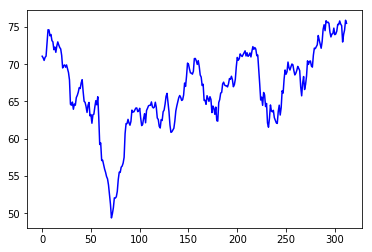

In [11]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [12]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\RL_10krep_arch0-option_T50-history_t15-dueling_typemax-freq300-batch64-capacity10000-lambda0.005-final
episode 100: 	0.02673223489342731	11.15
episode 200: 	0.028551051446369997	11.93
episode 300: 	0.02679130

episode 13600: 	0.026690334985260036	9.57
episode 13700: 	0.02785651425645451	10.44
episode 13800: 	0.03265946958216885	12.31
episode 13900: 	0.030863139063743387	10.45
episode 14000: 	0.027025922766648086	11.33
episode 14100: 	0.02718072572031603	10.35
episode 14200: 	0.03340274946302495	12.62
episode 14300: 	0.025078366480645715	10.16
episode 14400: 	0.03157983968569486	10.99
episode 14500: 	0.02684248642680228	11.37
episode 14600: 	0.026194389058962982	12.63
episode 14700: 	0.022016457001659096	11.79
episode 14800: 	0.0274134842786074	12.35
episode 14900: 	0.02831516980647997	9.26
episode 15000: 	0.03143965680289396	12.05
#Average reward per episode 15000: 0.028059831578664433
episode 15100: 	0.026178115211144864	10.3
episode 15200: 	0.02029195969192551	10.81
episode 15300: 	0.02767241392045088	10.16
episode 15400: 	0.032237052863560135	12.01
episode 15500: 	0.02090629855390737	9.23
episode 15600: 	0.029407349994535457	10.94
episode 15700: 	0.0248101633667392	12.53
episode 15800: 	0

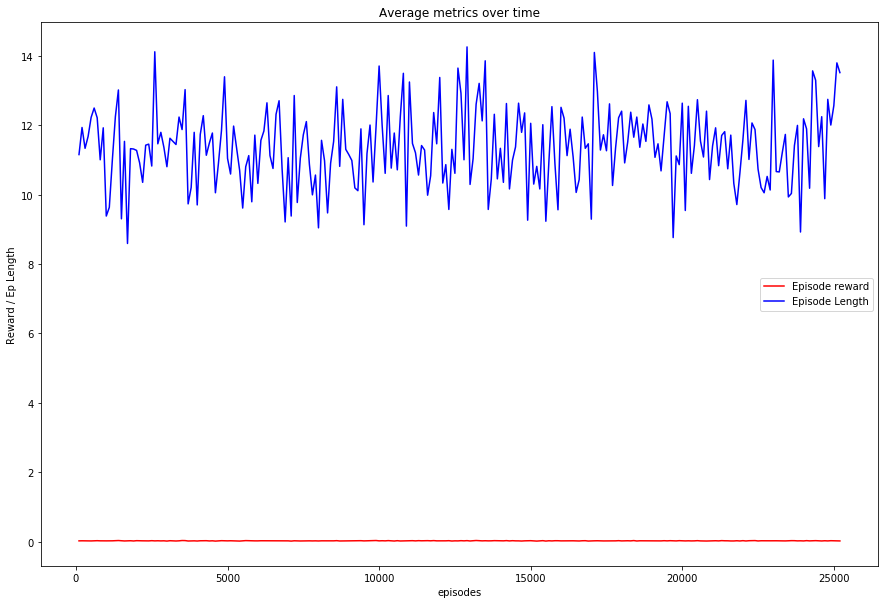

In [14]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

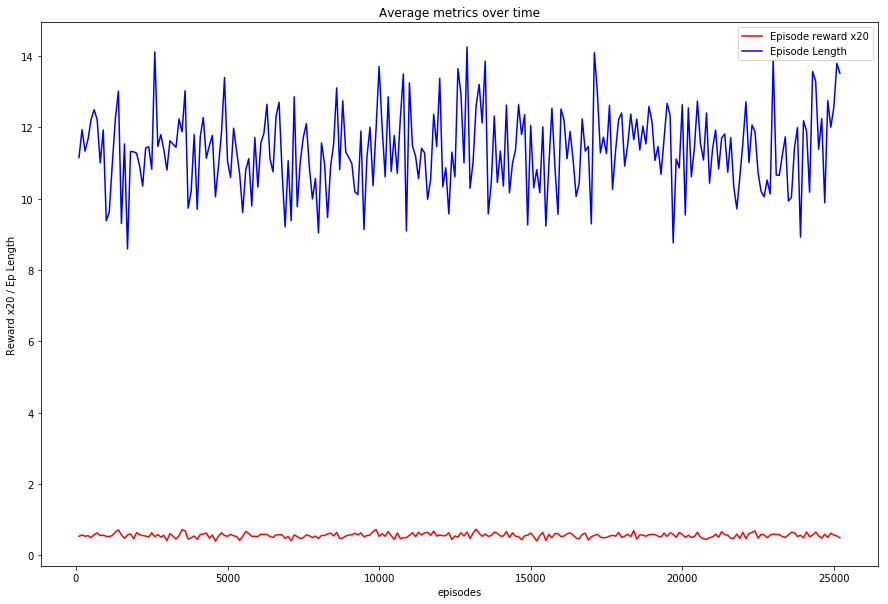

In [15]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

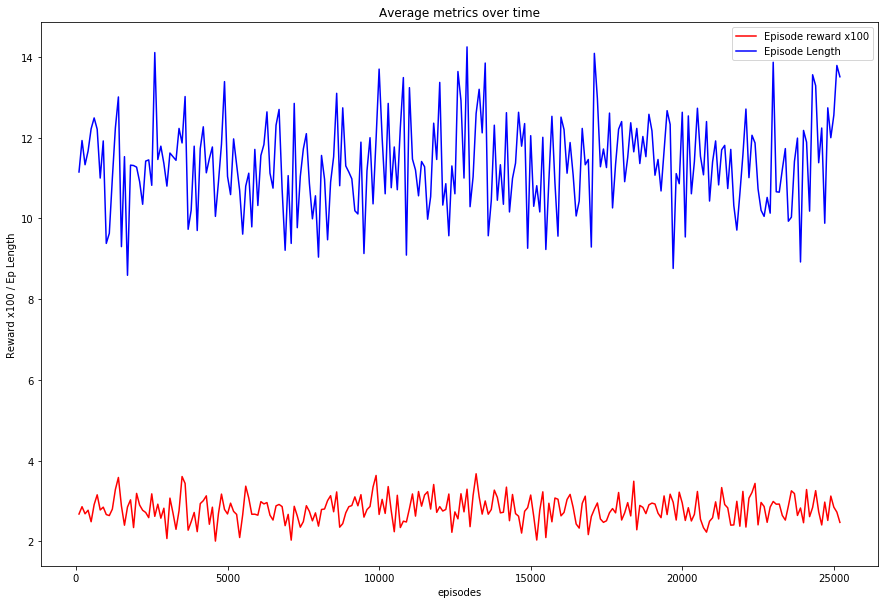

In [16]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

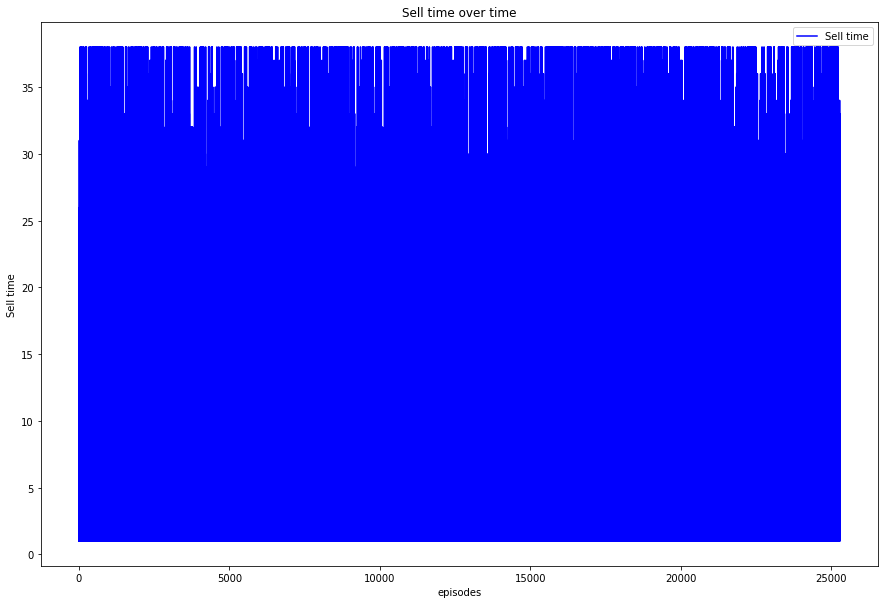

In [17]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

In [19]:
e=0

# Select random day over history to sell [Benchmark]

In [20]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.02095446822867575	11.55	0
episode 200: 	0.032988342117924924	11.56	0
episode 300: 	0.02632499577636844	11.3	0
episode 400: 	0.028426750925346637	13.99	0
episode 500: 	0.021061435955459173	12.99	0
episode 600: 	0.030551671251409465	15.0	0
episode 700: 	0.02848123611552245	12.07	0
episode 800: 	0.030321099491470566	13.22	0
episode 900: 	0.02178169287935003	12.29	0
episode 1000: 	0.021398182666302324	10.07	0
episode 1100: 	0.02141909756571308	10.52	0
episode 1200: 	0.029373753935811774	13.98	0
episode 1300: 	0.027308556524739715	14.31	0
episode 1400: 	0.03268399695574682	15.02	0
episode 1500: 	0.022612558761281158	10.95	0
episode 1600: 	0.026017615617209066	14.3	0
episode 1700: 	0.022705946904021935	9.12	0
episode 1800: 	0.029700855986258063	12.15	0
episode 1900: 	0.022565181808123277	11.53	0
episode 2000: 	0.028034785117666064	11.31	0
episode 2100: 	0.02636075845943769	12.15	0
episode 2200: 	0.02735280558672513	11.2	0
episode 2300: 	0.023273351251142674	13.18	0
episode 24

episode 18400: 	0.027653360594982232	13.38	0
episode 18500: 	0.019826573001958673	11.43	0
episode 18600: 	0.02126321442464524	11.42	0
episode 18700: 	0.029351326039044192	13.02	0
episode 18800: 	0.027573596208887254	11.89	0
episode 18900: 	0.030844743088278358	12.95	0
episode 19000: 	0.03257684541966751	12.49	0
episode 19100: 	0.024236400786370148	13.14	0
episode 19200: 	0.026207937017672676	14.32	0
episode 19300: 	0.020114862027235555	11.62	0
episode 19400: 	0.025446058498392606	13.36	0
episode 19500: 	0.02735853836466786	13.6	0
episode 19600: 	0.027986096259515016	12.8	0
episode 19700: 	0.03160156103752619	12.13	0
episode 19800: 	0.021464403046780708	12.17	0
episode 19900: 	0.02920247693801887	13.36	0
episode 20000: 	0.026305489053844843	12.08	0
#Average reward per episode 20000: 0.02628977150116024
episode 20100: 	0.019017691972473775	12.07	0
episode 20200: 	0.019415617407646798	12.36	0
episode 20300: 	0.021926864719520246	11.45	0
episode 20400: 	0.02061226229745932	11.9	0
episode 2

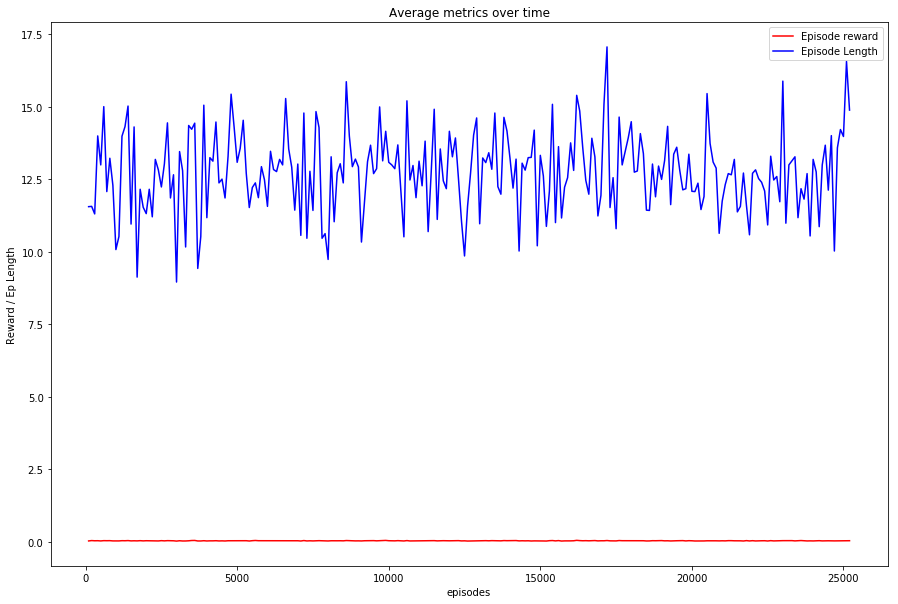

In [22]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

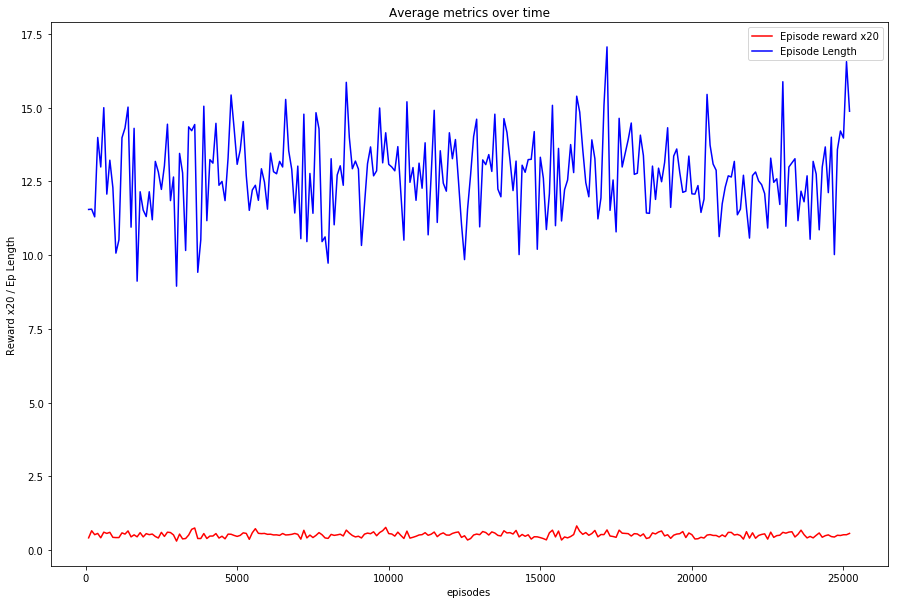

In [23]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

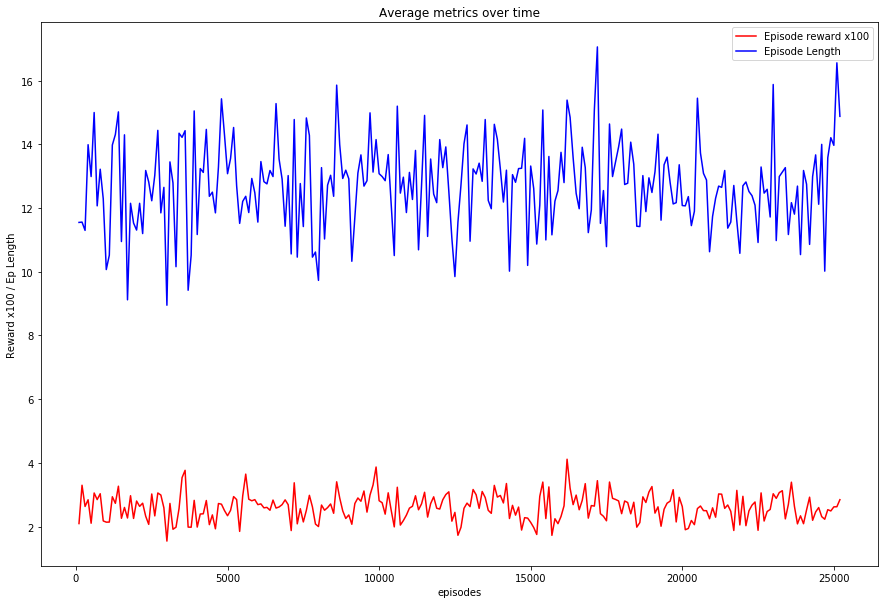

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

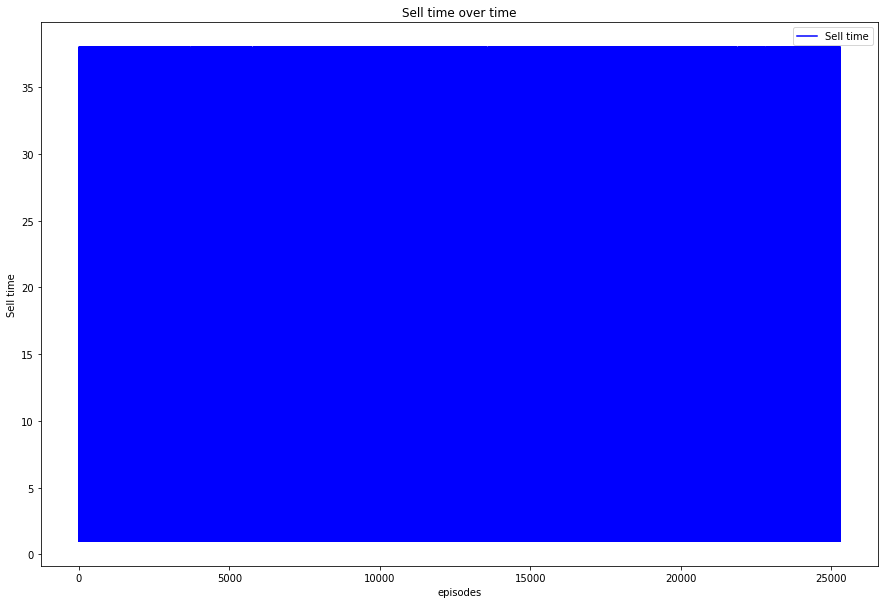

In [25]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [26]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.01836418670848209	13.95	0
episode 200: 	0.03201036167542599	14.69	0
episode 300: 	0.028716562836192575	18.02	0
episode 400: 	0.029567307116653146	15.43	0
episode 500: 	0.02409773539449739	16.91	0
episode 600: 	0.026460559257434645	17.65	0
episode 700: 	0.028223539634280623	15.8	0
episode 800: 	0.027992034151735786	16.54	0
episode 900: 	0.0186837534934307	14.32	0
episode 1000: 	0.015982429697512814	11.73	0
episode 1100: 	0.022330764773674884	14.32	0
episode 1200: 	0.03665321336723184	16.91	0
episode 1300: 	0.026090870555686697	15.43	0
episode 1400: 	0.027451258238186907	17.28	0
episode 1500: 	0.023545993116566702	13.95	0
episode 1600: 	0.024138514457398674	13.95	0
episode 1700: 	0.02201472752234683	12.47	0
episode 1800: 	0.028000644109265598	15.43	0
episode 1900: 	0.025820455479054608	14.32	0
episode 2000: 	0.025022870304274664	15.06	0
episode 2100: 	0.02224851956985125	13.95	0
episode 2200: 	0.027369147894273197	14.69	0
episode 2300: 	0.023029231454849072	15.8	0
episode

episode 18400: 	0.02771620747917702	14.32	0
episode 18500: 	0.01891023925632327	14.32	0
episode 18600: 	0.025835744527732123	15.8	0
episode 18700: 	0.02679714793013727	15.8	0
episode 18800: 	0.02651412706518441	13.58	0
episode 18900: 	0.029232250585667786	16.17	0
episode 19000: 	0.029359995981558897	17.28	0
episode 19100: 	0.021526358355140697	14.69	0
episode 19200: 	0.022513921573832266	16.91	0
episode 19300: 	0.020223725712536725	14.69	0
episode 19400: 	0.02451544913890382	15.43	0
episode 19500: 	0.026258351383121006	16.54	0
episode 19600: 	0.030315312514087256	17.65	0
episode 19700: 	0.029869168823247517	14.69	0
episode 19800: 	0.020658295101304538	14.32	0
episode 19900: 	0.026106290528961233	16.54	0
episode 20000: 	0.022401392826433043	14.32	0
#Average reward per episode 20000: 0.025935191809596716
episode 20100: 	0.015245634617736323	12.84	0
episode 20200: 	0.022415263987749547	16.17	0
episode 20300: 	0.022663291438898624	12.84	0
episode 20400: 	0.018821677377184657	12.47	0
episod

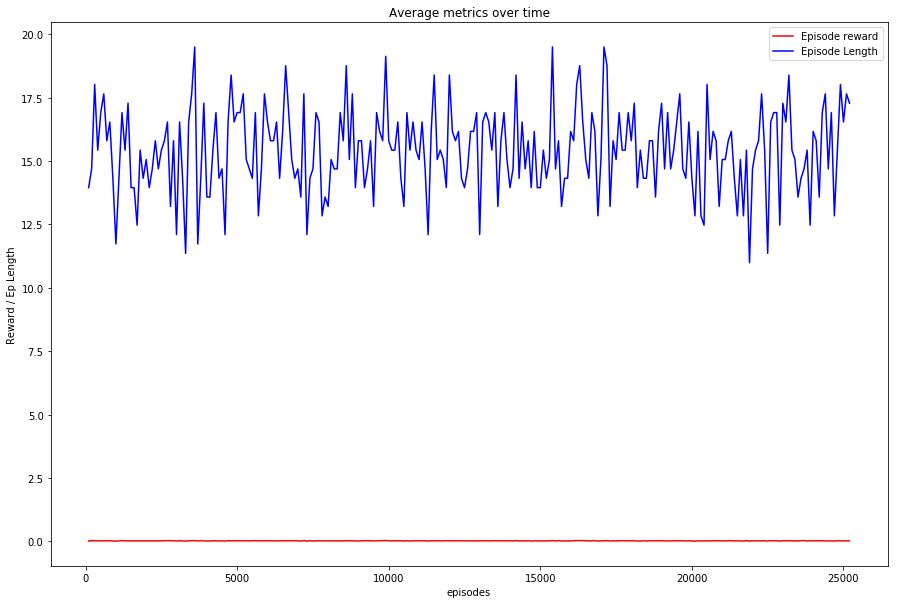

In [28]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

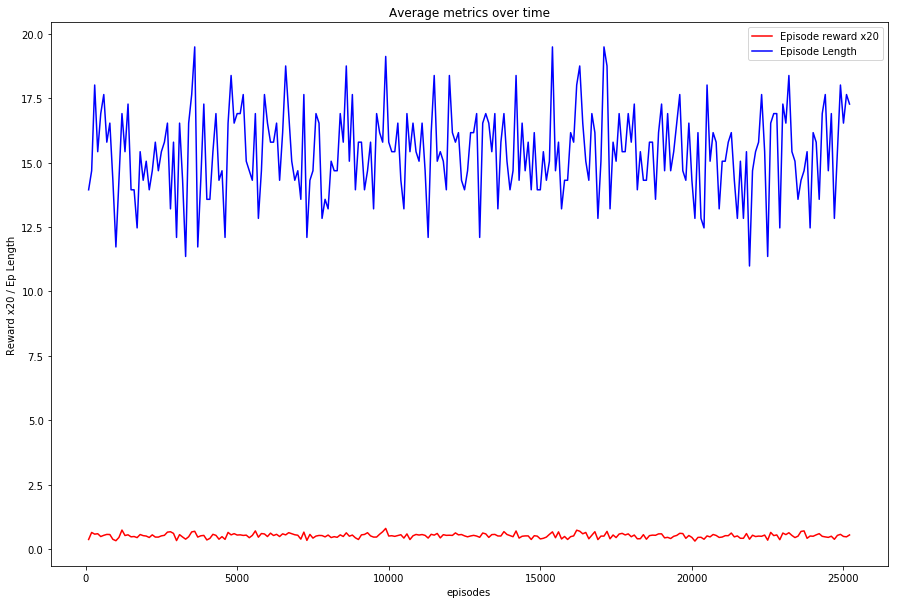

In [29]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

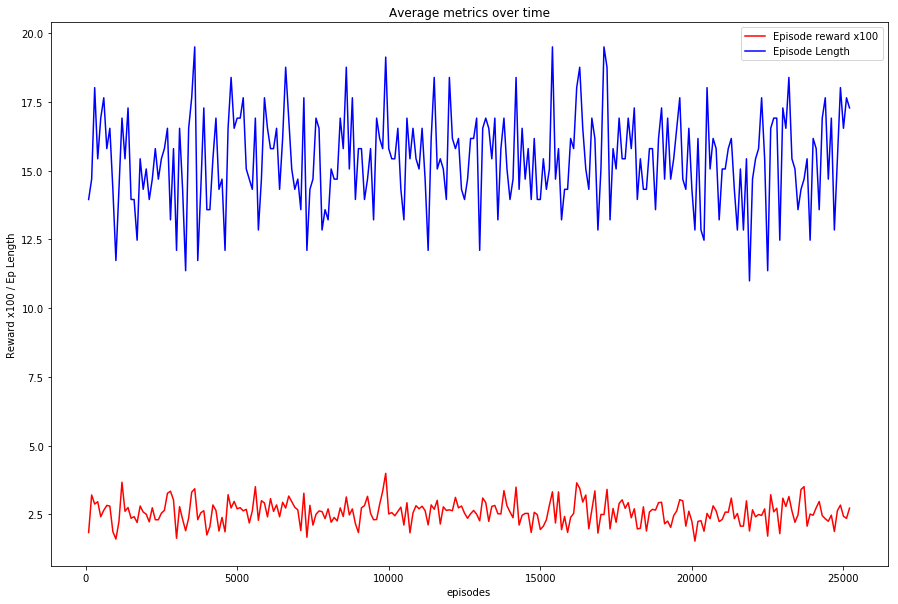

In [30]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

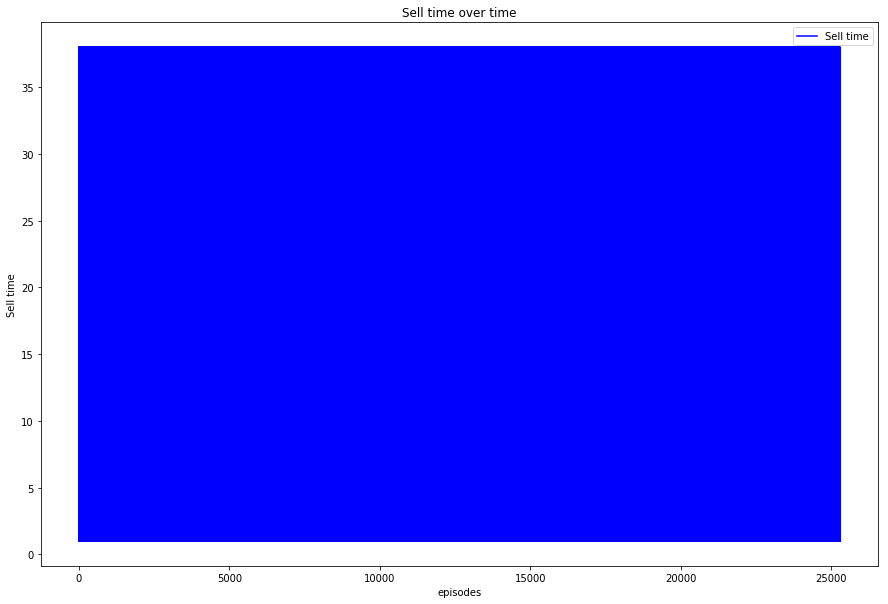

In [31]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select first day over history to sell [Benchmark]

In [32]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'FirstDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = [] 

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'FirstDay':
          sell_time = build_warm_up_state_t 
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'FirstDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.009930865711126885	6.55	0
episode 200: 	0.02082035361859961	6.92	0
episode 300: 	0.01870732640345682	7.66	0
episode 400: 	0.02015645038281781	8.77	0
episode 500: 	0.017726865425608442	10.99	0
episode 600: 	0.019053354313180292	10.25	0
episode 700: 	0.01720061059959447	7.66	0
episode 800: 	0.016307093099739895	9.14	0
episode 900: 	0.015332781935927275	7.29	0
episode 1000: 	0.012834584047168978	5.81	0
episode 1100: 	0.013797817786246171	5.81	0
episode 1200: 	0.019172957866988027	8.4	0
episode 1300: 	0.016786448404701577	9.88	0
episode 1400: 	0.020632075424368554	9.88	0
episode 1500: 	0.013767477271644221	7.66	0
episode 1600: 	0.01625819029483412	6.92	0
episode 1700: 	0.019619830172549972	6.18	0
episode 1800: 	0.024701578221402277	9.88	0
episode 1900: 	0.019480633865964155	6.55	0
episode 2000: 	0.018911372109663028	8.4	0
episode 2100: 	0.017129674201114612	6.92	0
episode 2200: 	0.014314961999916933	8.77	0
episode 2300: 	0.017348439628274325	8.03	0
episode 2400: 	0.01704679

episode 18800: 	0.022056015964659944	6.18	0
episode 18900: 	0.015611985084726063	8.77	0
episode 19000: 	0.020809892268148982	8.4	0
episode 19100: 	0.0153206476228695	7.29	0
episode 19200: 	0.017833787340820688	9.51	0
episode 19300: 	0.014447149974018036	7.66	0
episode 19400: 	0.01972256167920885	8.77	0
episode 19500: 	0.01871207376938919	9.88	0
episode 19600: 	0.014403975156298899	8.4	0
episode 19700: 	0.02033252010213073	8.4	0
episode 19800: 	0.021431004394216704	9.51	0
episode 19900: 	0.016844304324445225	9.14	0
episode 20000: 	0.01460615701501407	6.92	0
#Average reward per episode 20000: 0.017201020370818977
episode 20100: 	0.008629617776484052	5.81	0
episode 20200: 	0.010283883738385518	6.55	0
episode 20300: 	0.011300837057469178	5.07	0
episode 20400: 	0.008000215105520483	3.96	0
episode 20500: 	0.01471257644191619	8.03	0
episode 20600: 	0.014264424876142944	7.66	0
episode 20700: 	0.01811604308312776	7.66	0
episode 20800: 	0.015473827777201575	8.4	0
episode 20900: 	0.01471544355829

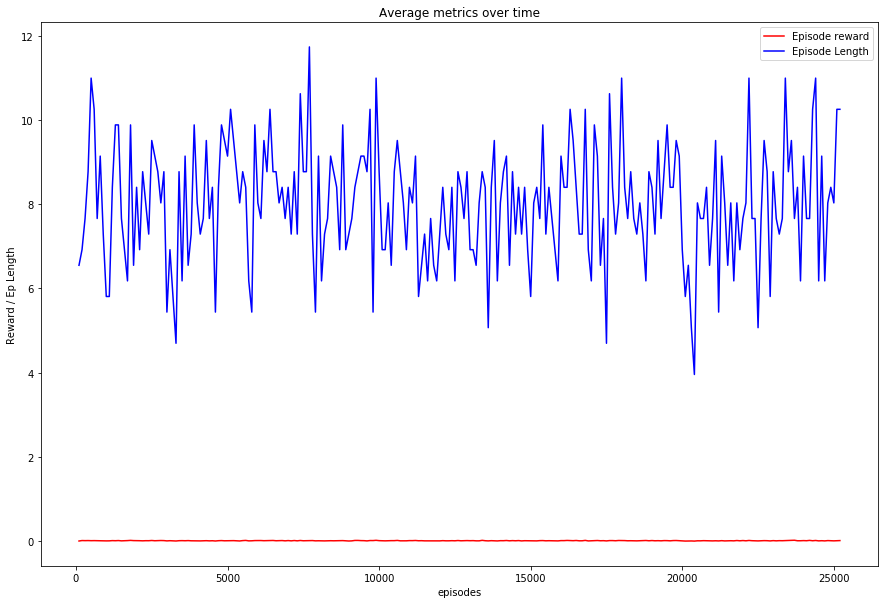

In [33]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

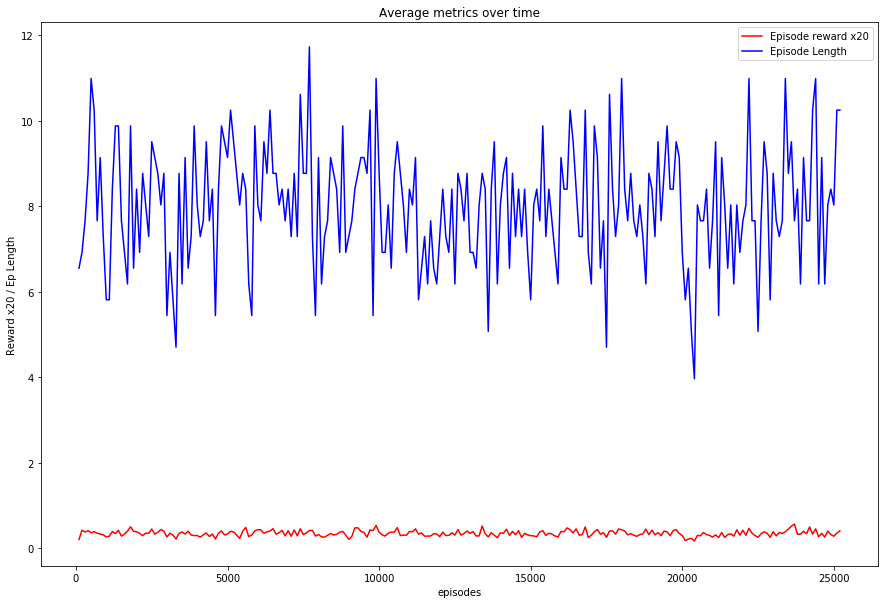

In [34]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

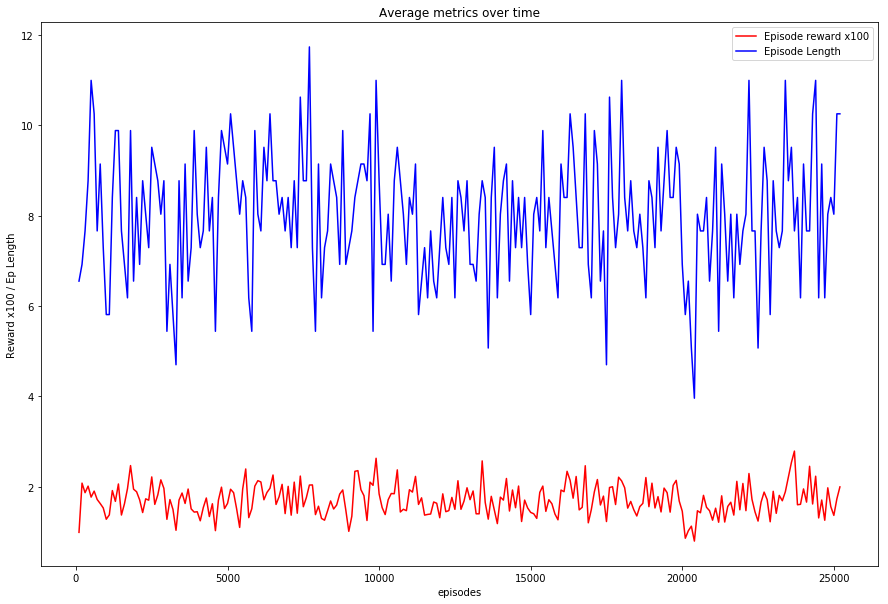

In [35]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

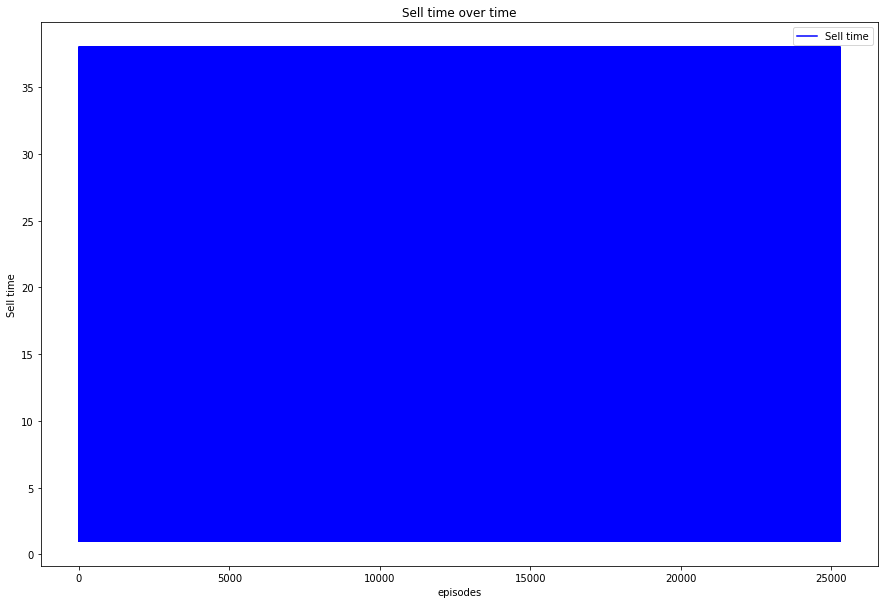

In [36]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 229
num_episodes_per_epoch: 14689
min value of stock: 65.53499984741211, max value of stock: 80.26499938964844


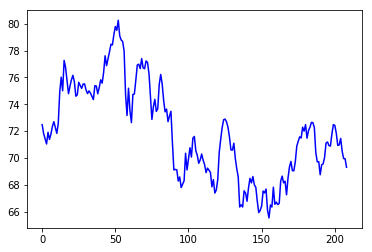

In [37]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [38]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\RL_10krep_arch0-option_T50-history_t15-dueling_typemax-freq300-batch64-capacity10000-lambda0.005-final
episode 100: 	0.023705254501923862	10.76
episode 200: 	0.029605712275628866	11.48
episode 300: 	0.025514342321488113	12.17
episode 400: 	0.025263472023174853	12.7
episode 500: 	0.033711934919247975	12.8
episode 600: 	0.027226121514916414	13.33
episode 700: 	0.026367433082455843	11.82
episode 800: 	0.030132835071045187	14.06
episode 900: 	0.03432360956600647	14.15
episode 1000: 	0.033314943962146744	11.89
episode 1100: 	0.02685419766912662	11.66
episode 1200: 	0.027610074602869895	11.77
episode 1300: 	0.027612664589175342	15.64
episode 1400: 	0.026073069598311172	13.37
episode 1500: 	0.02573515164076566	10.8
episode 1600: 	0.02793533153412285	13.17
episode 1700: 	0.02588756958652043	10.41
episode 1800: 	0.02863139809135227	12.85
episo

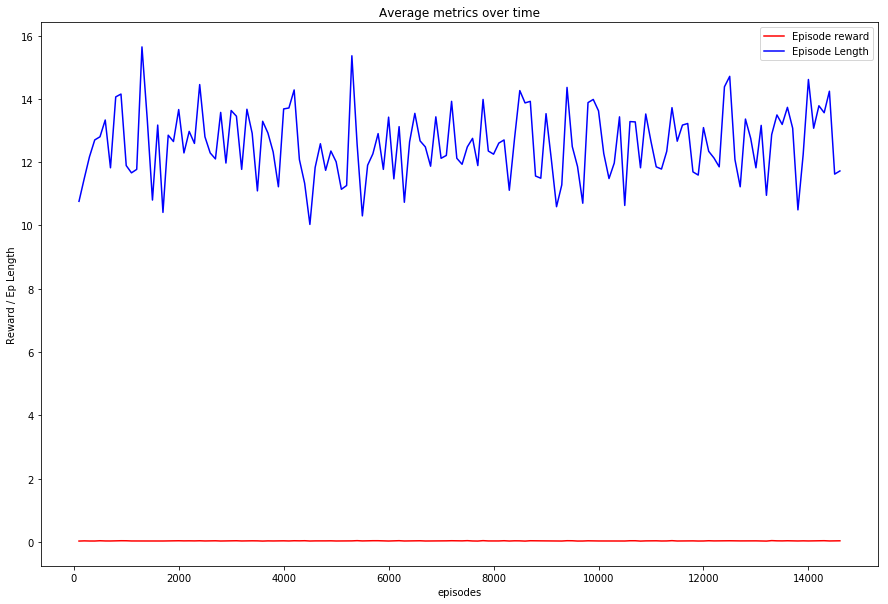

In [40]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

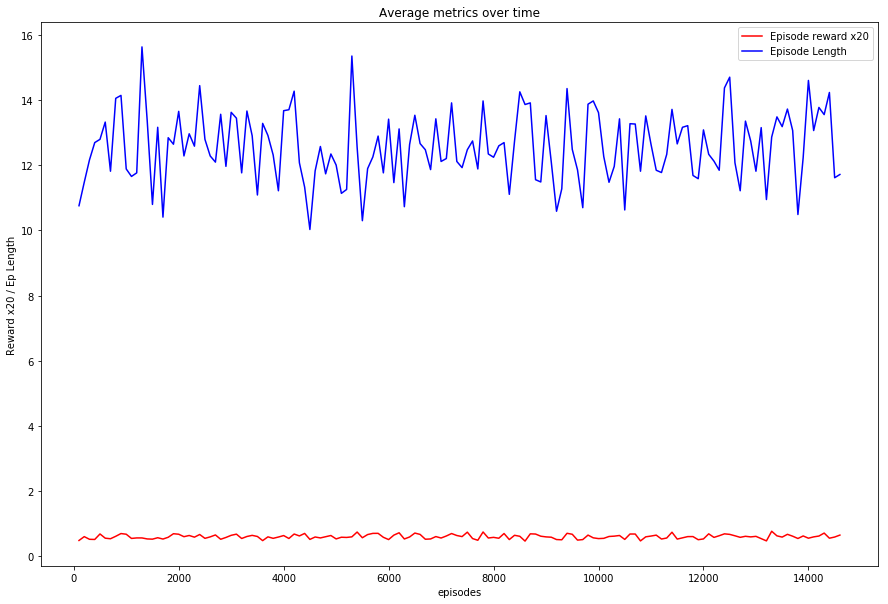

In [41]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

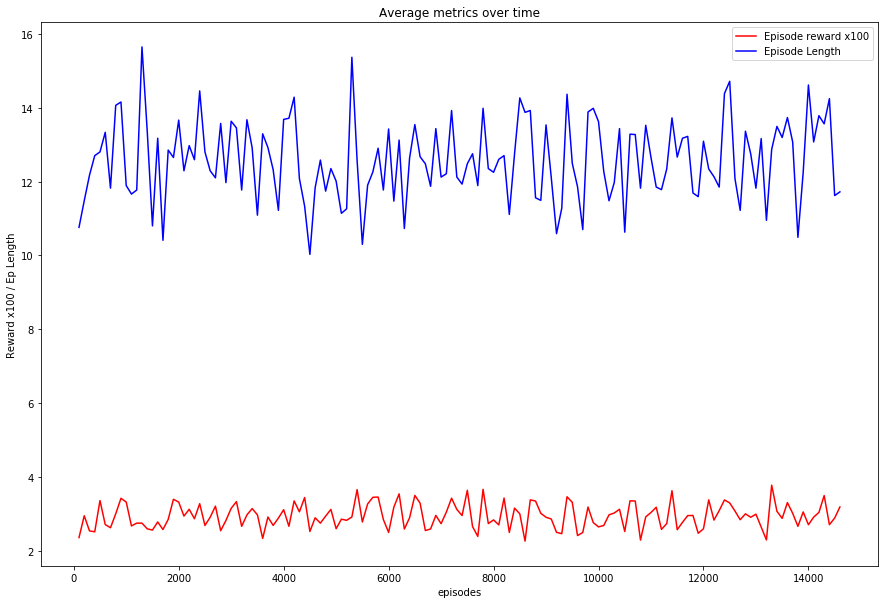

In [42]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

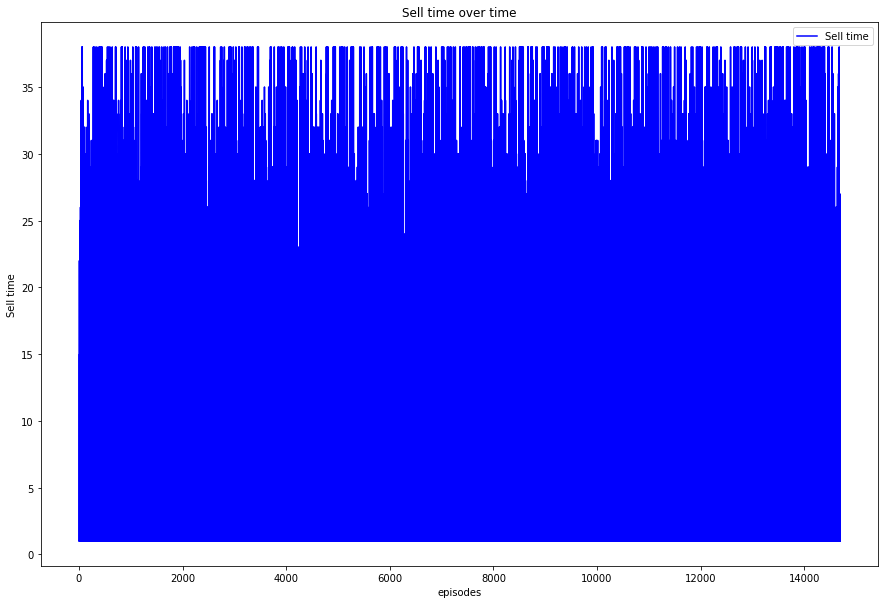

In [43]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [44]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.024097444861022145	12.99	0
episode 200: 	0.026494618451153005	13.53	0
episode 300: 	0.02260287912892618	13.51	0
episode 400: 	0.026462720516936846	14.12	0
episode 500: 	0.03773784039661786	16.28	0
episode 600: 	0.028509239880711176	15.83	0
episode 700: 	0.02455450569481611	14.2	0
episode 800: 	0.033670987090078784	16.65	0
episode 900: 	0.03310408206449006	17.07	0
episode 1000: 	0.03512173847267047	15.1	0
episode 1100: 	0.024451308648270567	15.85	0
episode 1200: 	0.02650131405399955	15.25	0
episode 1300: 	0.027771712197741234	17.24	0
episode 1400: 	0.02093309633958458	13.61	0
episode 1500: 	0.024923736961985955	13.98	0
episode 1600: 	0.026703360029916592	15.09	0
episode 1700: 	0.023705512847082763	13.53	0
episode 1800: 	0.020653152380858245	14.31	0
episode 1900: 	0.029472884361987167	14.06	0
episode 2000: 	0.029637329010159755	15.69	0
episode 2100: 	0.025388064339081598	12.35	0
episode 2200: 	0.026821411518857512	14.18	0
episode 2300: 	0.02419257354027255	14.85	0
episode

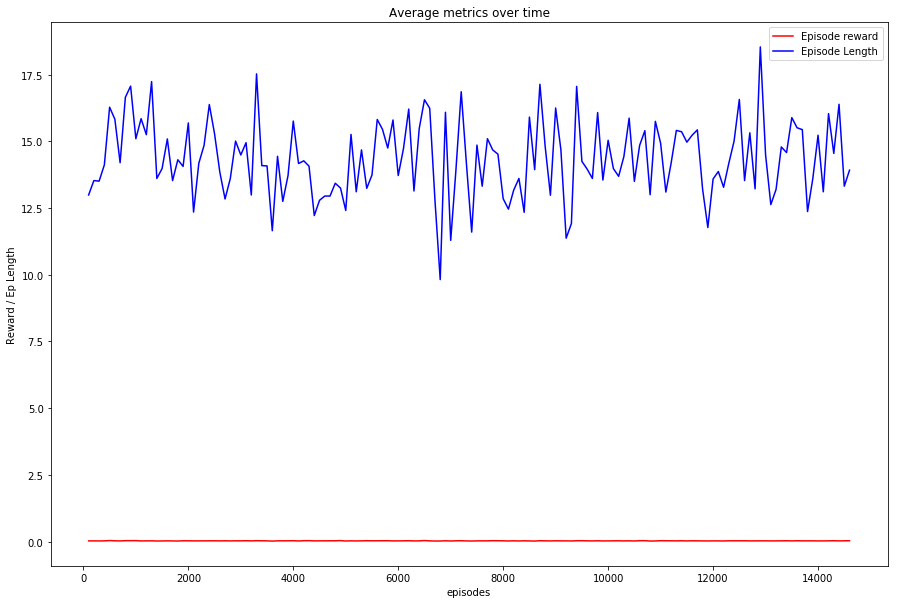

In [46]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

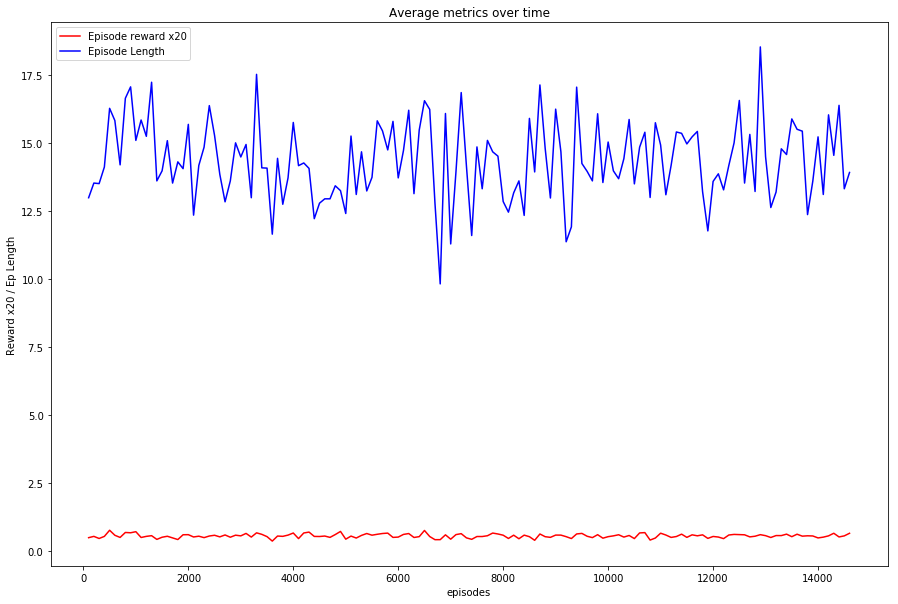

In [47]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

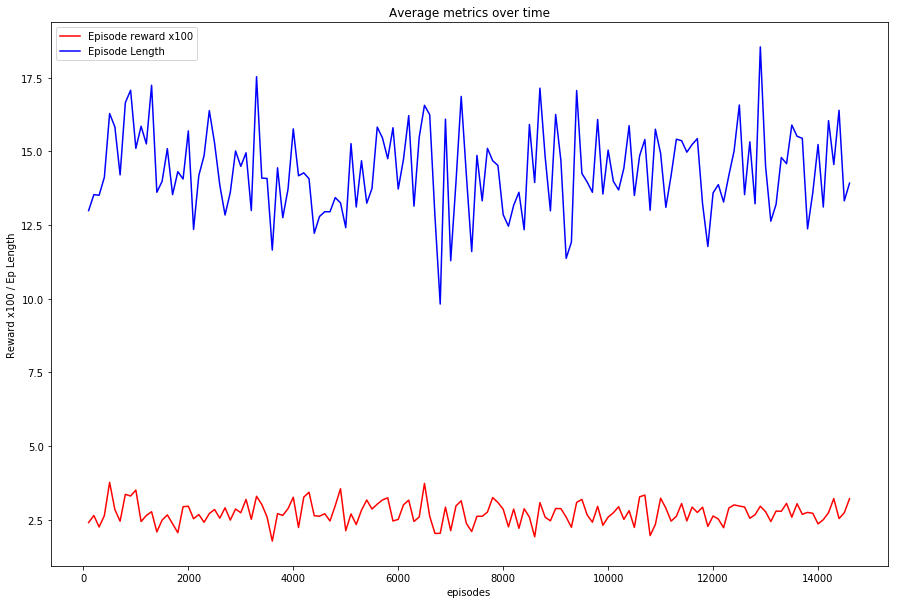

In [48]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

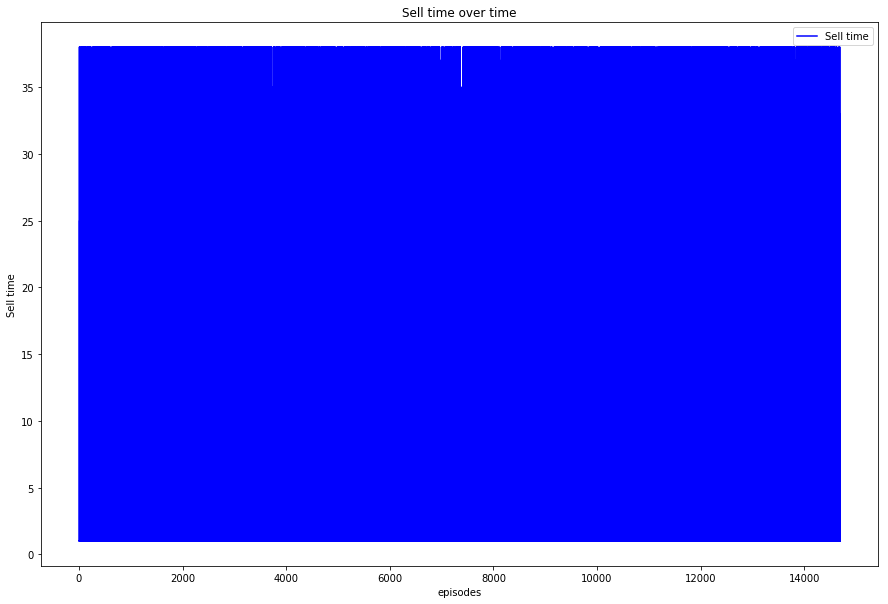

In [49]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [50]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.023622955597346645	15.43	0
episode 200: 	0.03079551827030195	18.02	0
episode 300: 	0.02330879526274629	16.54	0
episode 400: 	0.026790517951849266	17.65	0
episode 500: 	0.03480235846263092	18.39	0
episode 600: 	0.02583524424425039	16.54	0
episode 700: 	0.022457238563349313	15.43	0
episode 800: 	0.029710265660401115	20.61	0
episode 900: 	0.03647465031915609	22.09	0
episode 1000: 	0.03834061476120776	19.13	0
episode 1100: 	0.0261517644607158	17.65	0
episode 1200: 	0.027533735287674867	16.54	0
episode 1300: 	0.03534304701601345	21.35	0
episode 1400: 	0.019495382695327284	16.91	0
episode 1500: 	0.024775438355457084	15.43	0
episode 1600: 	0.027146687520511657	18.76	0
episode 1700: 	0.0227631706247942	15.8	0
episode 1800: 	0.026014522033244773	17.65	0
episode 1900: 	0.030812469165065956	18.02	0
episode 2000: 	0.03267550529815562	21.72	0
episode 2100: 	0.02843981442775645	16.91	0
episode 2200: 	0.02897418213442834	18.02	0
episode 2300: 	0.025198710746611418	18.02	0
episode 2400

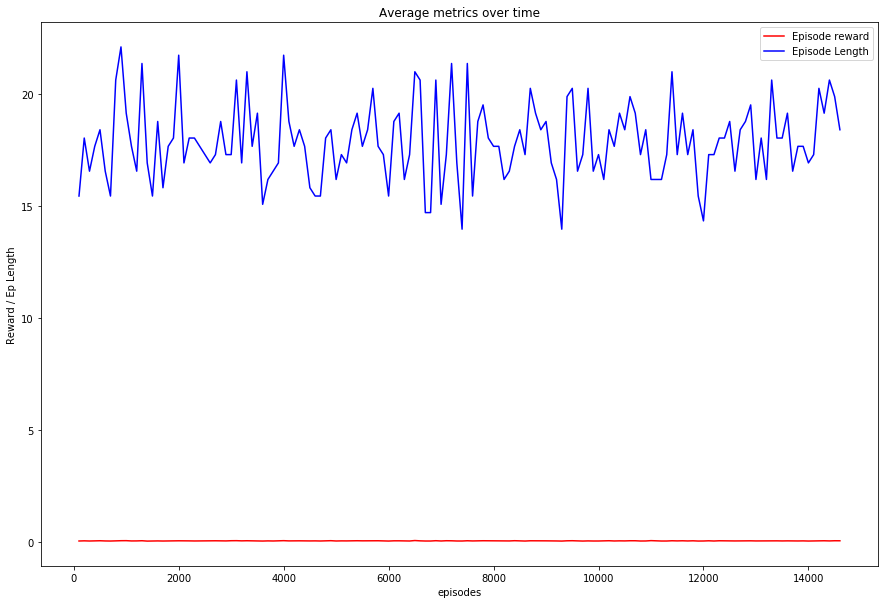

In [52]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

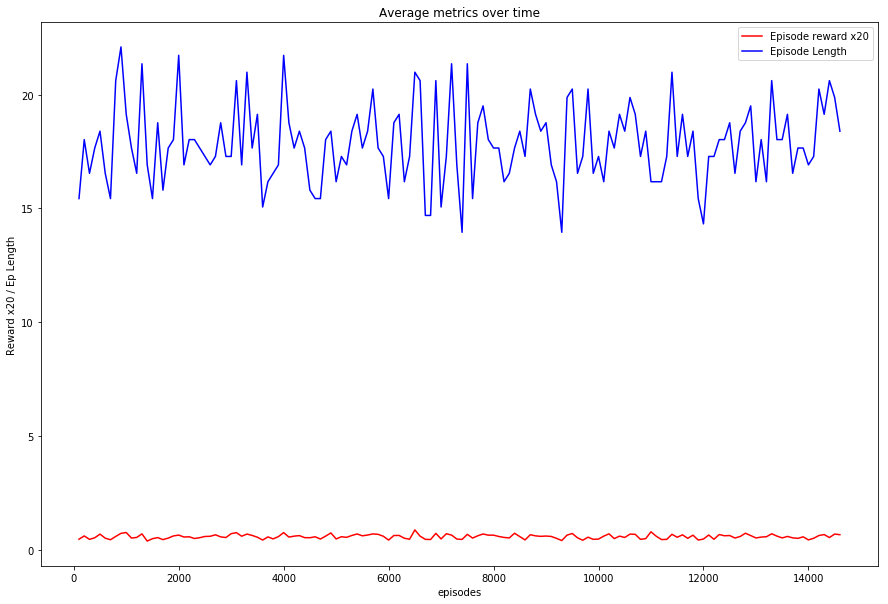

In [53]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

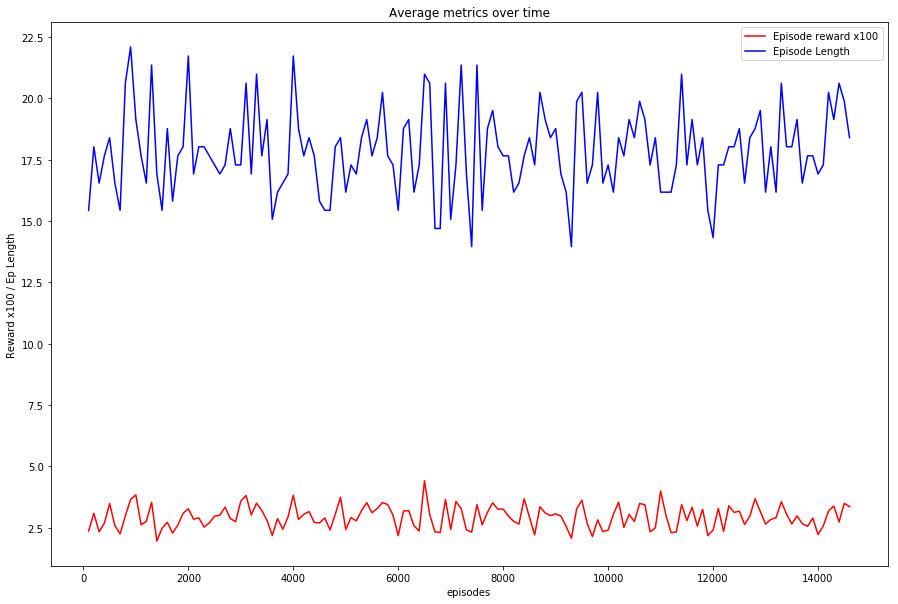

In [54]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

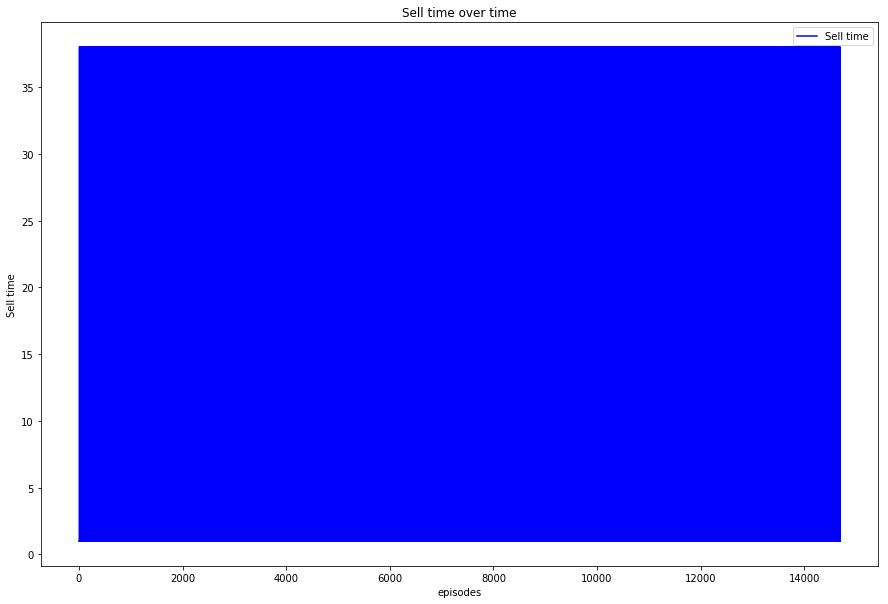

In [55]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select first day over history to sell [Benchmark]

In [56]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'FirstDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = [] 

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'FirstDay':
          sell_time = build_warm_up_state_t 
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'FirstDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.014530256037736217	8.77	0
episode 200: 	0.019176369458959775	8.4	0
episode 300: 	0.013068315482274164	8.77	0
episode 400: 	0.014480787638449037	8.4	0
episode 500: 	0.015829764027782734	7.66	0
episode 600: 	0.017967519579574244	9.88	0
episode 700: 	0.010959665220217414	7.29	0
episode 800: 	0.01872158988209782	10.25	0
episode 900: 	0.02450011757002197	14.32	0
episode 1000: 	0.023400820197949566	8.03	0
episode 1100: 	0.017990111446190626	10.62	0
episode 1200: 	0.01766095666374949	10.25	0
episode 1300: 	0.02527701470084021	13.58	0
episode 1400: 	0.013115703951502002	8.03	0
episode 1500: 	0.01711380786182169	9.14	0
episode 1600: 	0.021495667944400037	11.73	0
episode 1700: 	0.01569845247788001	9.51	0
episode 1800: 	0.016577277917148157	8.77	0
episode 1900: 	0.011243754952525673	6.92	0
episode 2000: 	0.02289810850308043	11.36	0
episode 2100: 	0.015208156031501163	8.03	0
episode 2200: 	0.01802279397655521	8.4	0
episode 2300: 	0.01894800864204337	10.62	0
episode 2400: 	0.0200863

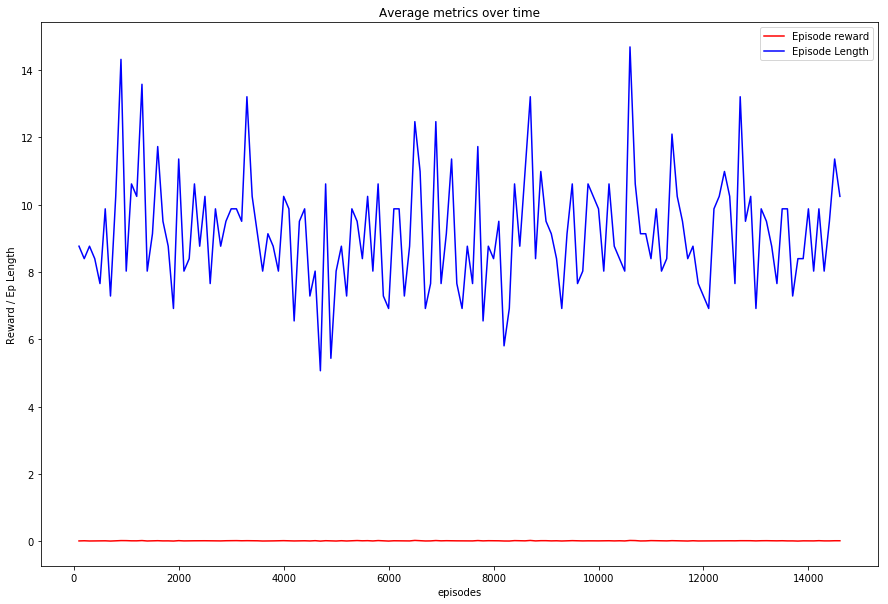

In [57]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

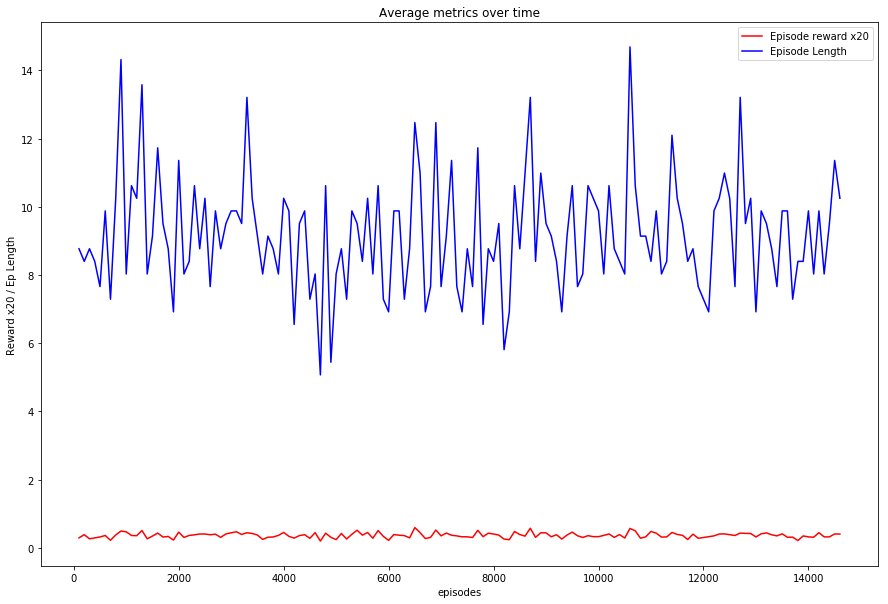

In [58]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

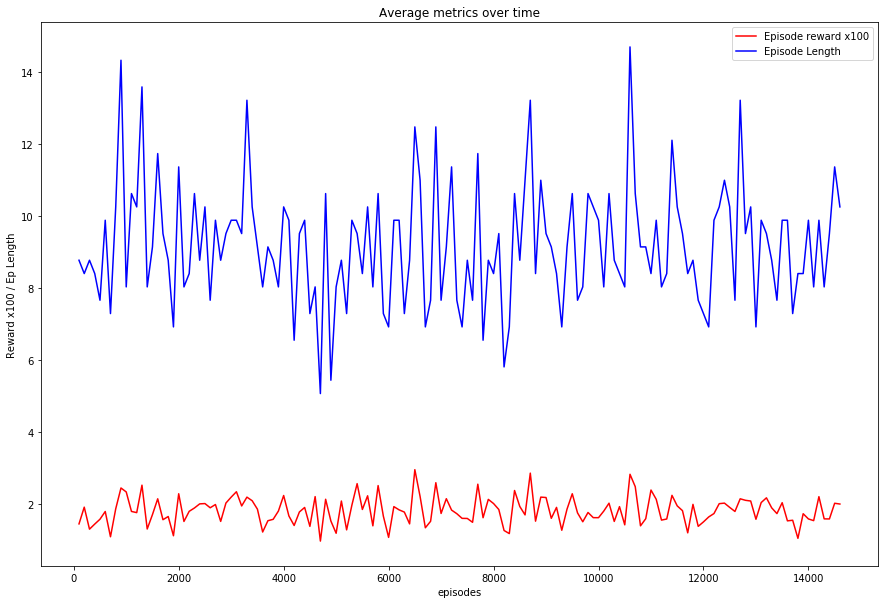

In [59]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

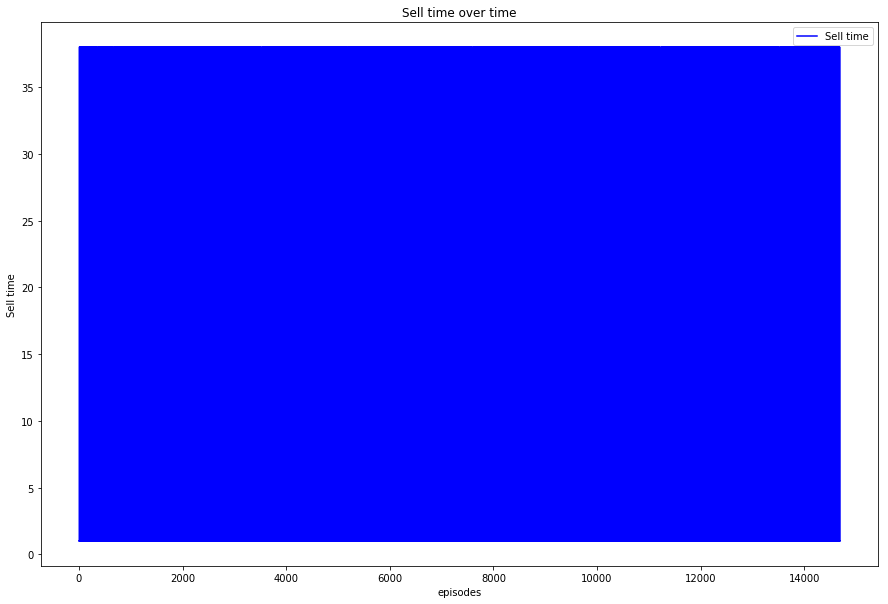

In [60]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [61]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

jList: 124920
maxPossibleOptionP_returnList: 124920
maxPossibleOptionR_P_returnList: 124920
maxPossibleP_returnList: 124920
maxPossibleR_P_returnList: 124920
maxPossiblerList: 124920
option_percentage_rList: 124920
option_real_percentage_rList: 124920
percentage_rList: 124920
rList: 124920
real_percentage_rList: 124920
sTimeList: 124920
real_test_data: 2600
test_data: 2600
Qnetwork: 2000
StockEnv: 2000
real_train_data: 1768
train_data: 1768
AvgEpisodeList: 1248
AvgrList: 1248
AvgsTimeList: 1248
AmericanOptionPricing: 1056
GBM: 1056
MinMaxScaler: 1056
experience_buffer: 1056
real_stocks_test_data: 912
real_stocks_train_data: 912
stock_names: 912
stocks_test_data: 912
stocks_train_data: 912
stock_names_all: 880
episodeBuffer: 528
stock_names_2: 440
path: 333
final_trained_model_name: 246
trained_model_name: 240
s1P: 232
sP: 232
build_data: 136
leaky_relu: 136
length: 136
normalize_data: 136
prepare_company_stock: 136
prepare_company_stock_yahoo: 136
prepare_data: 136
processState: 136
se